In [58]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
from keras.datasets import mnist

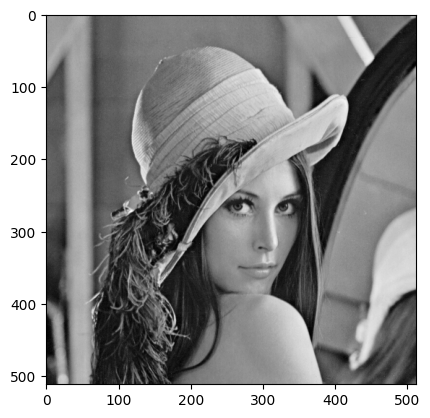

(512, 512)

In [59]:
img = cv2.imread('lena.png',cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img,cmap='gray')
plt.show()
img.shape

# Convolution operation

In [60]:
import numpy as np

class Conv_op:
    def __init__(self, num_filters, filter_size, padding=0, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        # Normalizing the filter values
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size) / (filter_size * filter_size)
        self.image = None  # Initialize the image attribute

    # Generator function with padding and stride
    def image_region(self, image):
        height, width = image.shape
        if self.padding > 0:
            image = np.pad(image, [(self.padding, self.padding), (self.padding, self.padding)], mode='constant', constant_values=0)
        for j in range(0, height - self.filter_size + 1 + 2 * self.padding, self.stride):
            for k in range(0, width - self.filter_size + 1 + 2 * self.padding, self.stride):
                image_patch = image[j:(j + self.filter_size), k:(k + self.filter_size)]
                yield image_patch, j // self.stride, k // self.stride

    def forward_prop(self, image):
        height, width = image.shape
        if self.padding > 0:
            image = np.pad(image, [(self.padding, self.padding), (self.padding, self.padding)], mode='constant', constant_values=0)
        conv_height = (height - self.filter_size + 2 * self.padding) // self.stride + 1
        conv_width = (width - self.filter_size + 2 * self.padding) // self.stride + 1
        conv_out = np.zeros((conv_height, conv_width, self.num_filters))
        self.image = image  # Store the image here
        for image_patch, i, j in self.image_region(image):
            if i < conv_height and j < conv_width:
                conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis=(1, 2))
        return conv_out

    # Updating filter weights, using gradient descent
    def back_prop(self, dl_dout, learning_rate):
        if self.image is None:
            raise ValueError("Image has not been set. Please run forward_prop first.")
        dl_df = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            if i < dl_dout.shape[0] and j < dl_dout.shape[1]:
                for k in range(self.num_filters):
                    dl_df[k] += image_patch * dl_dout[i, j, k]
        self.conv_filter -= learning_rate * dl_df
        return dl_df


In [61]:
#no of filters, and size of filter
conn  = Conv_op(18,8)
out = conn.forward_prop(img)
out.shape

(505, 505, 18)

see all 18 images by changing the filter in the given below operation

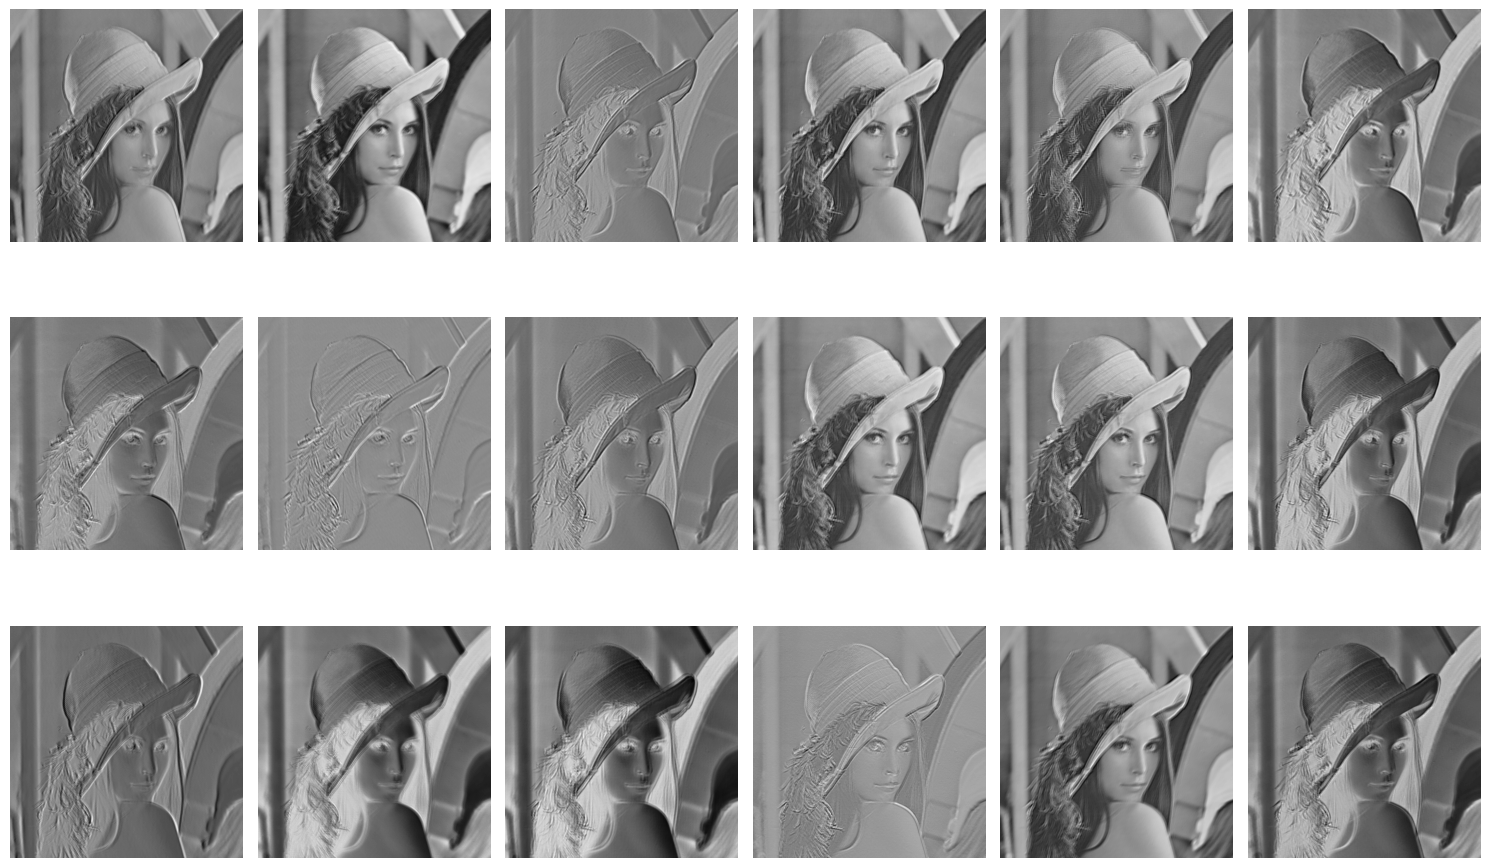

In [62]:
num_filters = 18
cols = 6
rows = num_filters // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i in range(num_filters):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(out[:,:,i], cmap='gray')
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

= (512,512)\*(18,8\*8)

= (512-8+1)\*(512-8+1)


= (505,505)


In [63]:
out.shape

(505, 505, 18)

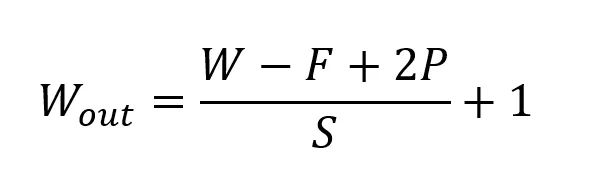

# Max Pooling

In [64]:
import numpy as np

class Max_Pool:
    def __init__(self, filter_size, padding=0, stride=1):
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.image = None  # Initialize the image attribute

    def image_region(self, image):
        # Calculate the dimensions of the padded image
        height, width, num_filters = image.shape
        if self.padding > 0:
            image = np.pad(image, [(self.padding, self.padding), (self.padding, self.padding), (0, 0)], mode='constant', constant_values=0)

        # Calculate output dimensions
        new_height = (height + 2 * self.padding - self.filter_size) // self.stride + 1
        new_width = (width + 2 * self.padding - self.filter_size) // self.stride + 1

        for i in range(0, new_height * self.stride, self.stride):
            for j in range(0, new_width * self.stride, self.stride):
                image_patch = image[i:i + self.filter_size, j:j + self.filter_size]
                yield image_patch, i // self.stride, j // self.stride

    def forward_prop(self, image):
        self.image = image  # Store the image in the class
        height, width, num_filters = image.shape
        if self.padding > 0:
            image = np.pad(image, [(self.padding, self.padding), (self.padding, self.padding), (0, 0)], mode='constant', constant_values=0)

        new_height = (height - self.filter_size + 2 * self.padding) // self.stride + 1
        new_width = (width - self.filter_size + 2 * self.padding) // self.stride + 1
        output = np.zeros((new_height, new_width, num_filters))

        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[i*self.stride:i*self.stride+self.filter_size, j*self.stride:j*self.stride+self.filter_size]
                output[i, j] = np.amax(image_patch, axis=(0, 1))
        return output

    def back_prop(self, dL_dout):
        if self.image is None:
            raise ValueError("Image has not been set. Please run forward_prop first.")

        dL_dmax_pool = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            max_val = np.amax(image_patch, axis=(0, 1))

            for i1 in range(self.filter_size):
                for j1 in range(self.filter_size):
                    for k1 in range(num_filters):
                        if image_patch[i1, j1, k1] == max_val[k1]:
                            dL_dmax_pool[i + i1, j + j1, k1] += dL_dout[i // self.stride, j // self.stride, k1]
        return dL_dmax_pool


In [65]:
print(out.shape)
conn2  = Max_Pool(10)
out2 = conn2.forward_prop(out)
out2.shape

(505, 505, 18)


(496, 496, 18)

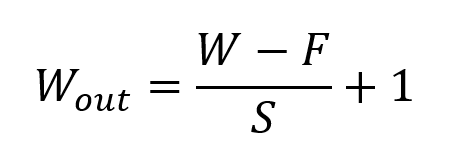

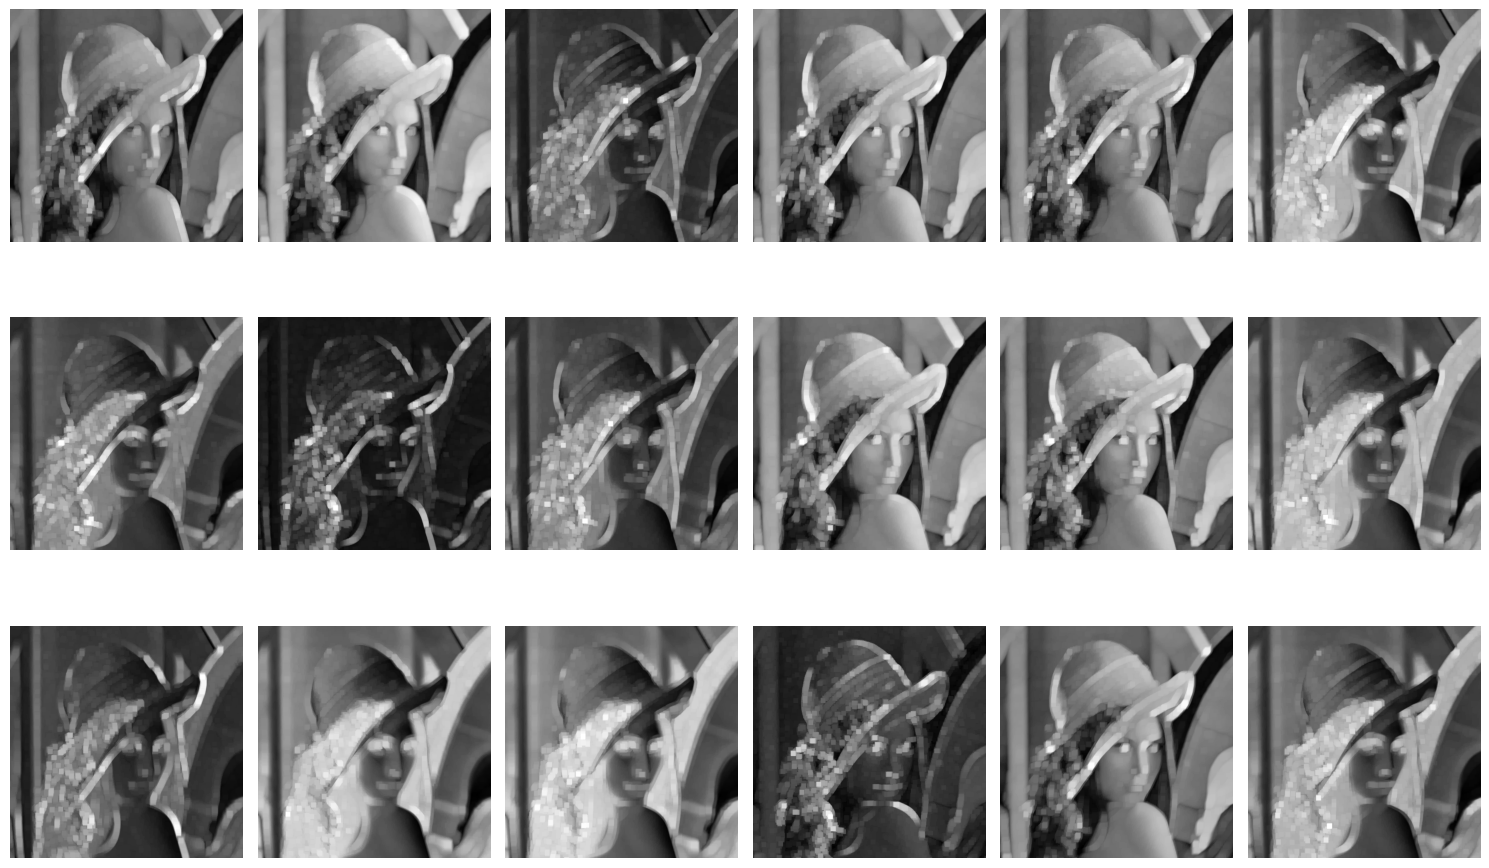

In [66]:
num_filters = 18
cols = 6
rows = num_filters // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i in range(num_filters):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(out2[:,:,i], cmap='gray')
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Softmax

In [67]:
import numpy as np

class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward_prop(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def back_prop(self, d_L_d_out, learn_rate):
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

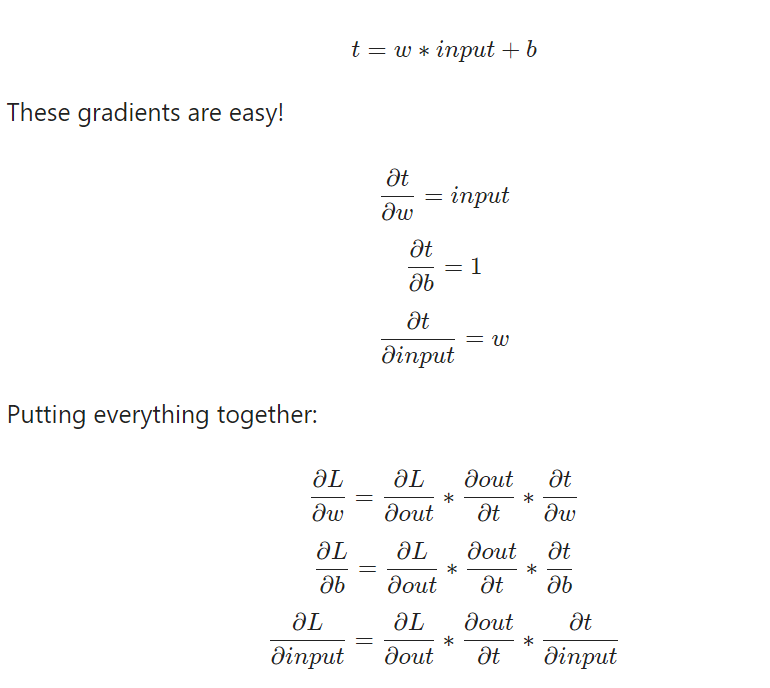

In [68]:
conn3 = Softmax(496*496*18,10)
out3 = conn3.forward_prop(out2)
out3

#10 outputs, each indicating probability of image belonging to that class

array([0.0999956 , 0.09999864, 0.10000236, 0.10000066, 0.09999874,
       0.10000012, 0.10000071, 0.10000031, 0.09999987, 0.10000298])

# Mnist

(28 + 2*0 - 3) / 1 + 1 = 26


(26 - 2) / 1 + 1 = 25


In [74]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

train_images = x_train[:1000]
train_labels = y_train[:1000]
test_images = x_test[:1000]
test_labels = y_test[:1000]

train_images[1].shape

conv = Conv_op(8,3,0,1)
pool = Max_Pool(2,0,1)
softmax = Softmax(25*25*8,10)

In [78]:
def cnn_forward_prop(image,label):
  out_p = conv.forward_prop((image/255)-0.2)
  out_p = pool.forward_prop(out_p)
  out_p = softmax.forward_prop(out_p)

  cross_entropy_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_entropy_loss,accuracy_eval

In [75]:
def training_cnn(image,label,learn_rate=0.0005):
  out,loss,acc = cnn_forward_prop(image,label)

  #calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1/out[label]

  #backpropogation
  grad_back = softmax.back_prop(gradient,learn_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back,learn_rate)

  return loss,acc

In [79]:
for epoch in range(4):
  print('Epoch %d ---->' % (epoch+1))

  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  #training the CNN
  loss = 0
  num_correct = 0
  for i,(im,label) in enumerate(zip(train_images,train_labels)):
    if i%100 == 0:
      print('%d / 1000: avg loss %.3f and acc: %d%%' % (i+1,loss/100,num_correct))
      loss = 0
      num_correct = 0
    l1,acc = training_cnn(im,label)
    loss += l1
    num_correct += acc

Epoch 1 ---->
1 / 1000: avg loss 0.000 and acc: 0%
101 / 1000: avg loss 0.468 and acc: 87%
201 / 1000: avg loss 0.347 and acc: 90%
301 / 1000: avg loss 0.362 and acc: 89%
401 / 1000: avg loss 0.413 and acc: 88%
501 / 1000: avg loss 0.436 and acc: 89%
601 / 1000: avg loss 0.412 and acc: 85%
701 / 1000: avg loss 0.388 and acc: 87%
801 / 1000: avg loss 0.300 and acc: 93%
901 / 1000: avg loss 0.322 and acc: 92%
Epoch 2 ---->
1 / 1000: avg loss 0.000 and acc: 0%
101 / 1000: avg loss 0.186 and acc: 95%
201 / 1000: avg loss 0.213 and acc: 93%
301 / 1000: avg loss 0.345 and acc: 92%
401 / 1000: avg loss 0.499 and acc: 87%
501 / 1000: avg loss 0.316 and acc: 90%
601 / 1000: avg loss 0.427 and acc: 84%
701 / 1000: avg loss 0.245 and acc: 94%
801 / 1000: avg loss 0.249 and acc: 96%
901 / 1000: avg loss 0.337 and acc: 90%
Epoch 3 ---->
1 / 1000: avg loss 0.000 and acc: 0%
101 / 1000: avg loss 0.297 and acc: 90%
201 / 1000: avg loss 0.497 and acc: 89%
301 / 1000: avg loss 0.308 and acc: 91%
401 / 1

In [80]:
print('Testing phase')
loss = 0
num_correct = 0
for im,label in zip(test_images,test_labels):
  _,l1,acc = cnn_forward_prop(im,label)
  loss += l1
  num_correct += acc

num_tests = len(test_images)
print('Test loss:',loss/num_tests)
print('Test accuracy:',num_correct/num_tests)

Testing phase
Test loss: 0.4631617938401665
Test accuracy: 0.845


Article followed

https://victorzhou.com/blog/intro-to-cnns-part-2/
